 # Stores Sales Forecasting

https://github.com/marcellobenedetti92/predizione-vendite-settimanali-walmart/blob/main/progetto_finale_codice.ipynb

In [1]:
# import libraries
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#### unzip the dataset

In [ ]:
!cd walmart-recruiting-store-sales-forecasting/

In [10]:
!unzip walmart-recruiting-store-sales-forecasting/train.csv.zip

Archive:  walmart-recruiting-store-sales-forecasting/train.csv.zip
  inflating: train.csv               


In [12]:
!unzip walmart-recruiting-store-sales-forecasting/test.csv.zip

Archive:  walmart-recruiting-store-sales-forecasting/test.csv.zip
  inflating: test.csv                


In [13]:
!unzip walmart-recruiting-store-sales-forecasting/features.csv.zip

Archive:  walmart-recruiting-store-sales-forecasting/features.csv.zip
  inflating: features.csv            


In [14]:
!unzip walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip

Archive:  walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


### Understand and explore the Data

**Stores**: Type and size of each store

In [5]:
stores = pd.read_csv('stores.csv')

print(stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


**Train**: Historical sales data including store, department, date, weekly sales, and holiday indicator.

In [6]:
train = pd.read_csv('train.csv')

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None


**Test**: Similar to train but without the Weekly_Sales.

In [7]:
test = pd.read_csv('test.csv')

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB
None


**Features**: Contains additional information such as temperature, fuel price, markdowns, CPI, unemployment, and holiday indicator.

In [8]:
features = pd.read_csv('features.csv')

print(features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None


In [16]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [18]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [19]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Handle missing values

In [20]:
stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [21]:
train.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [22]:
test.isna().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [23]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [47]:
def msno_matrix(df):
    df_ = df.copy()
    missing_ratios = df_.notnull().mean() * 100
    df_.columns = [f"{col}\n{ratio:.1f}%" for col, ratio in zip(df_.columns, missing_ratios)]
    msno.matrix(df_)
    plt.title('Missing Value Matrix and Percentage of Complete Values', fontsize=20)
    plt.show()

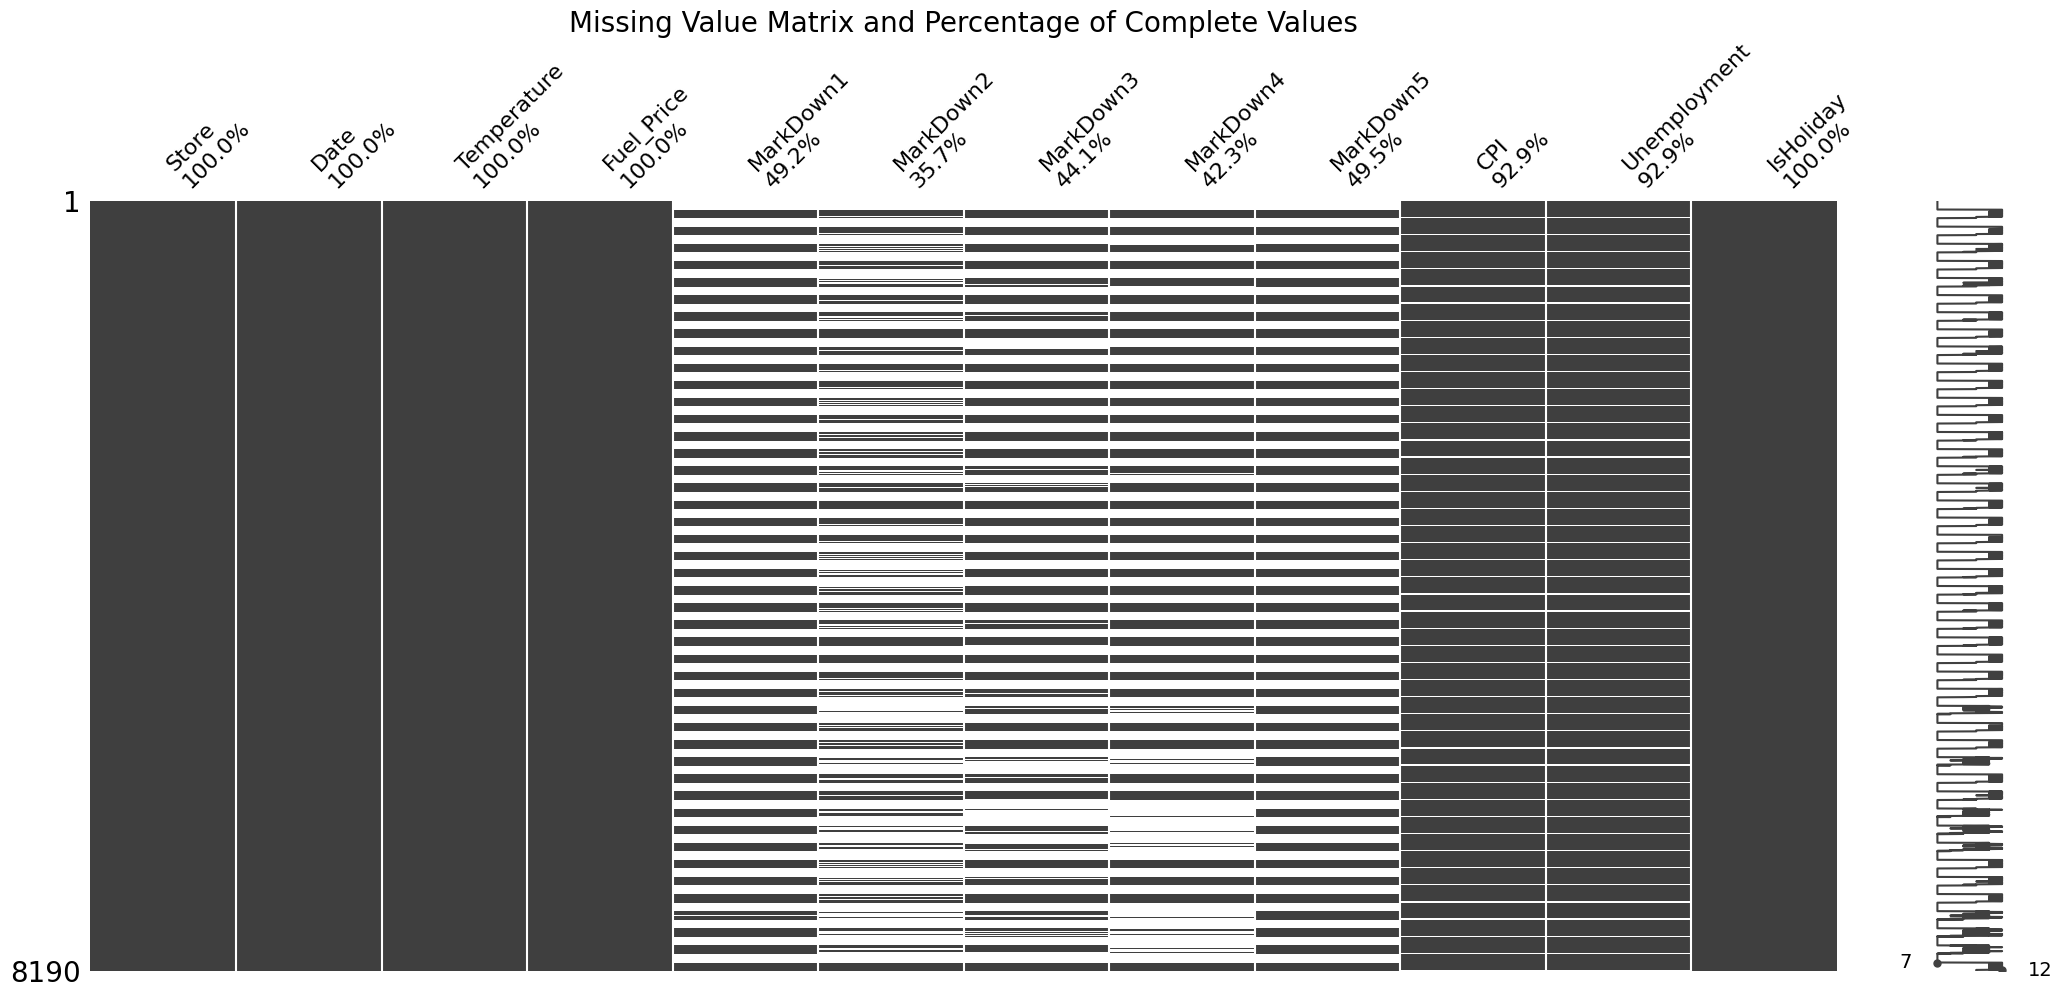

In [48]:
msno_matrix(features)

While mean imputation is simple, it can reduce the variance in your data and potentially underestimate the uncertainty in your predictions. 

In [36]:
numerical_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

for column in numerical_columns:
    mean_value = features[column].mean()
    features[column].fillna(mean_value, inplace=True)

features.isnull().sum()

/var/folders/t9/2w32j6693bgcszqz42m0h9k00000gn/T/ipykernel_4357/2178962150.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features[column].fillna(mean_value, inplace=True)


Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

Using K-Nearest Neighbors (KNN) for imputation is a more sophisticated approach that can potentially capture more complex relationships in your data.

The scaler, specifically the StandardScaler from scikit-learn, performs standardization on the data. This operation is important for KNN imputation for several reasons. Let's break it down:
What StandardScaler does:

1. For each feature, it calculates the mean (μ) and standard deviation (σ) of the values.
2. It then transforms each value (x) using the formula: (x - μ) / σ

This transformation results in each feature having a mean of 0 and a standard deviation of 1.

Why scaling is needed for KNN imputation:

1. Equal feature importance: KNN uses distances between data points to determine "nearest neighbors". Without scaling, features with larger magnitudes would dominate the distance calculations. 
2. Improved accuracy: By standardizing, we ensure that all features contribute equally to the distance calculations, which generally leads to more accurate imputation.
3. Algorithm assumptions: Many machine learning algorithms, including KNN, assume that all features are on a similar scale. Standardization helps meet this assumption.
4. Numerical stability: Some algorithms can face numerical instability or slow convergence when features are on very different scales. Standardization helps mitigate these issues.

After imputation, we use inverse_transform() to convert the data back to its original scale, ensuring that our imputed values are in the same range as the original data.

In [9]:
# Assuming 'features' is your DataFrame
numerical_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

# Create a copy of the numerical columns
features_numeric = features[numerical_columns].copy()

# Standardize the features (important for KNN)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_numeric)

# Create and fit the KNN imputer
imputer = KNNImputer(n_neighbors=5)  
features_imputed = imputer.fit_transform(features_scaled)

# Convert back to original scale
features_imputed = scaler.inverse_transform(features_imputed)

# Create a new DataFrame with the imputed values
features_imputed_df = pd.DataFrame(features_imputed, columns=numerical_columns, index=features.index)

# Replace the original columns with the imputed ones
features[numerical_columns] = features_imputed_df

# Check for any remaining null values
print(features[numerical_columns].isnull().sum())

MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


#### Feature Engineering

In [10]:
# first merge train, features and stores data
features_stores = features.merge(stores, how='inner', on='Store')
features_stores.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,5427.498,1311.012,11515.138,1713.214,9606.41,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,5427.498,1311.012,11515.138,1713.214,9606.41,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,5427.498,1311.012,11515.138,1713.214,9606.41,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,5427.498,1311.012,11515.138,1713.214,9606.41,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,5427.498,1311.012,11515.138,1713.214,9606.41,211.350143,8.106,False,A,151315


In [11]:
train_merged = train.merge(features_stores, how='inner', on=['Store', 'Date', 'IsHoliday'])
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,5427.498,1311.012,11515.138,1713.214,9606.41,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,5427.498,1311.012,11515.138,1713.214,9606.41,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,5427.498,1311.012,11515.138,1713.214,9606.41,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,5427.498,1311.012,11515.138,1713.214,9606.41,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,5427.498,1311.012,11515.138,1713.214,9606.41,211.350143,8.106,A,151315


In [12]:
# prepare also for test
test_merged = test.merge(features_stores, how='inner', on=['Store', 'Date', 'IsHoliday'])
test_merged.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.700,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.890,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.100,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.170,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,485.072,3838.35,150.57,6966.34,223.610984,6.573,A,151315


extract year, month, week and day and create new column for them

In [13]:
# Convert 'Date' column to datetime format
train_merged['Date'] = pd.to_datetime(train_merged['Date'])

# Extract date features
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
train_merged['DayOfWeek'] = train_merged['Date'].dt.dayofweek  

train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,DayOfWeek
0,1,1,2010-02-05,24924.50,False,42.31,2.572,5427.498,1311.012,11515.138,1713.214,9606.41,211.096358,8.106,A,151315,2010,2,5,4
1,1,1,2010-02-12,46039.49,True,38.51,2.548,5427.498,1311.012,11515.138,1713.214,9606.41,211.242170,8.106,A,151315,2010,2,6,4
2,1,1,2010-02-19,41595.55,False,39.93,2.514,5427.498,1311.012,11515.138,1713.214,9606.41,211.289143,8.106,A,151315,2010,2,7,4
3,1,1,2010-02-26,19403.54,False,46.63,2.561,5427.498,1311.012,11515.138,1713.214,9606.41,211.319643,8.106,A,151315,2010,2,8,4
4,1,1,2010-03-05,21827.90,False,46.50,2.625,5427.498,1311.012,11515.138,1713.214,9606.41,211.350143,8.106,A,151315,2010,3,9,4


Lag Features: Lag features are created to capture the temporal dependencies in the data. In the context of time series data, a lag feature is a copy of the original series shifted by a certain number of time steps. For example, Weekly_Sales_Lag1 is the Weekly_Sales value from the previous week, Weekly_Sales_Lag2 is the value from two weeks ago, and so on.

In [54]:
# Lag Features: Create lagged features for sales to capture trends

# Define the number of lag weeks
num_lags = 4

for i in range(1, num_lags + 1):
    train_merged[f'Weekly_Sales_Lag{i}'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(i)

train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Year,Month,Week,DayOfWeek,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_Lag4
0,1,1,2010-02-05,24924.50,False,42.31,2.572,5427.498,1311.012,11515.138,...,A,151315,2010,2,5,4,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,38.51,2.548,5427.498,1311.012,11515.138,...,A,151315,2010,2,6,4,24924.50,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,39.93,2.514,5427.498,1311.012,11515.138,...,A,151315,2010,2,7,4,46039.49,24924.50,NaN,NaN
3,1,1,2010-02-26,19403.54,False,46.63,2.561,5427.498,1311.012,11515.138,...,A,151315,2010,2,8,4,41595.55,46039.49,24924.50,NaN
4,1,1,2010-03-05,21827.90,False,46.50,2.625,5427.498,1311.012,11515.138,...,A,151315,2010,3,9,4,19403.54,41595.55,46039.49,24924.5


Rolling Features: Calculate rolling means or sums to smooth out sales trends

In [55]:
# Define the window size for rolling features
window_size = 4

train_merged['Rolling_Mean_Sales'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].rolling(window=window_size, min_periods=1).mean().reset_index(drop=True)
train_merged['Rolling_Sum_Sales'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].rolling(window=window_size, min_periods=1).sum().reset_index(drop=True)

train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Year,Month,Week,DayOfWeek,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_Lag4,Rolling_Mean_Sales,Rolling_Sum_Sales
0,1,1,2010-02-05,24924.50,False,42.31,2.572,5427.498,1311.012,11515.138,...,2010,2,5,4,NaN,NaN,NaN,NaN,24924.500000,24924.50
1,1,1,2010-02-12,46039.49,True,38.51,2.548,5427.498,1311.012,11515.138,...,2010,2,6,4,24924.50,NaN,NaN,NaN,35481.995000,70963.99
2,1,1,2010-02-19,41595.55,False,39.93,2.514,5427.498,1311.012,11515.138,...,2010,2,7,4,46039.49,24924.50,NaN,NaN,37519.846667,112559.54
3,1,1,2010-02-26,19403.54,False,46.63,2.561,5427.498,1311.012,11515.138,...,2010,2,8,4,41595.55,46039.49,24924.50,NaN,32990.770000,131963.08
4,1,1,2010-03-05,21827.90,False,46.50,2.625,5427.498,1311.012,11515.138,...,2010,3,9,4,19403.54,41595.55,46039.49,24924.5,32216.620000,128866.48


### Data exploration & visualization

In [33]:
train_merged.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Year,Month,Week,DayOfWeek,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_Lag4,Rolling_Mean_Sales,Rolling_Sum_Sales
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,...,421570.000000,421570.000000,421570.0,421570.0,418239.000000,414945.000000,411681.000000,408436.000000,421570.000000,4.215700e+05
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,6444.143587,3553.894953,3528.963728,2711.472016,4784.501046,...,2010.968591,6.449510,25.826762,4.0,15999.603935,16017.800755,16032.715911,16043.625770,15995.078364,6.327715e+04
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6122.940122,6358.939941,7790.397393,4281.831900,4238.105729,...,0.796876,3.243217,14.151887,0.0,22727.073873,22741.336370,22751.245887,22754.401147,22250.552856,8.834046e+04
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,...,2010.000000,1.000000,1.0,4.0,-4988.940000,-4988.940000,-4988.940000,-4988.940000,-1750.000000,-3.958000e+03
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2475.982000,267.018000,12.290000,584.496000,2373.050000,...,2010.000000,4.000000,14.0,4.0,2090.030000,2100.850000,2109.260000,2118.075000,2144.895000,8.400000e+03
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5427.498000,1311.012000,80.046000,1713.214000,4087.290000,...,2011.000000,6.000000,26.0,4.0,7625.990000,7639.580000,7651.470000,7663.510000,7725.020000,3.037108e+04
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9001.748000,4285.096000,5723.310000,2883.670000,6404.840000,...,2012.000000,9.000000,38.0,4.0,20226.575000,20254.120000,20273.260000,20286.882500,20306.633750,8.028071e+04
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,...,2012.000000,12.000000,52.0,4.0,693099.360000,693099.360000,693099.360000,693099.360000,339472.757500,1.357891e+06


Considerations:

**Store and Department**:
There are 45 stores (min: 1, max: 45) and 99 departments (min: 1, max: 99) in the dataset. This suggests a large retail chain with diverse product categories.

**Weekly Sales**:
The average weekly sales are $15,981.26, with a high standard deviation of $22,711.18. There's a wide range of sales values, from negative (-$4,988.94) to very high ($693,099.36). The negative sales could indicate returns or adjustments, which might need further investigation.

**Temperature and Fuel Price**:
Temperatures range from -2.06°F to 100.14°F, indicating diverse climates across store locations. Fuel prices vary from $2.47 to $4.47, which could impact shopping behaviors.


**Markdowns**:

All markdown columns (MarkDown1 to MarkDown5) show considerable variability, with some having negative values:

MarkDown1: mean of $6,444.14 
MarkDown2: mean of $3,553.89 
MarkDown3: mean of $3,528.96 
MarkDown4: mean of $2,711.47 
MarkDown5: mean of $4,784.50 

This suggests diverse promotional strategies across stores and time periods.

**New Economic Indicators**:
Consumer Price Index (CPI) ranges from 126.064 to 227.233, with a mean of 171.202.
Unemployment rates vary from 3.879% to 14.313%, with an average of 7.96%.
These economic factors could influence consumer spending patterns.


**Store Characteristics**:
Store sizes range from 34,875 to 219,622 (presumably square feet), with an average of 136,728.
The variation in store size might correlate with location types (urban, suburban, rural) or store formats.


**Time-related features**:
The data spans from 2010 to 2012.
There's an even distribution across months (1-12) and weeks (1-52).
All entries are for the same day of the week (4), likely Friday if weeks start on Sunday, likely indicating weekly data collection..


**Sales Trends**:
Rolling mean sales and rolling sum sales provide smoothed versions of the sales data, with ranges consistent with the Weekly_Sales column. 
The maximum rolling mean ($339,472.76) is lower than the maximum weekly sales, indicating some smoothing of extreme values.


**Data Completeness**:
All columns now have the full count of 421,570 entries, indicating that the KNN imputation has filled in any missing values.

In [34]:
test_merged.describe()

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000
mean,22.238207,44.339524,53.941804,3.581546,7680.244561,3156.276085,2253.119823,3001.468214,3922.681189,178.023142,6.966794,136497.688921
std,12.809930,30.656410,18.724153,0.239442,10694.737162,7436.231463,13199.213175,7205.093686,19445.150745,35.353547,1.368861,61106.926438
min,1.000000,1.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.220000,-185.170000,130.586349,3.684000,34875.000000
25%,11.000000,18.000000,39.820000,3.431000,1963.550000,233.520000,13.610000,104.160000,1309.300000,138.884429,6.156800,93638.000000
50%,22.000000,37.000000,54.470000,3.606000,4828.720000,658.852000,70.000000,615.560000,2390.430000,182.154146,6.953000,140167.000000
75%,33.000000,74.000000,67.350000,3.766000,9427.410000,2043.000000,261.100000,2637.430000,4227.270000,215.134781,7.879200,202505.000000
max,45.000000,99.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000,219622.000000


In [35]:
train_merged.Type.value_counts()

Type
A    215478
B    163495
C     42597
Name: count, dtype: int64

In [36]:
train_merged.Year.value_counts()

Year
2011    153453
2010    140679
2012    127438
Name: count, dtype: int64

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

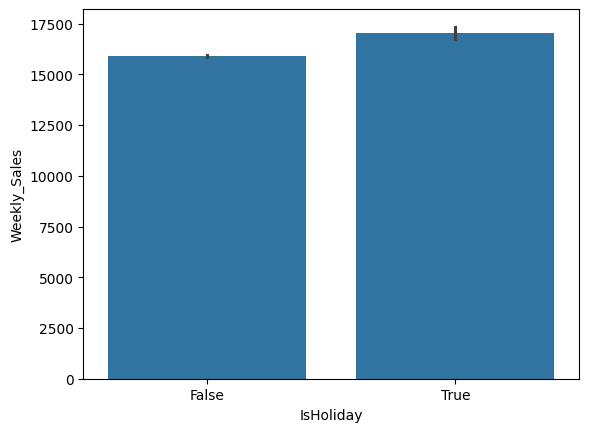

In [53]:
# WeeklySales per IsHoliday
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train_merged)

This graph compares the average weekly sales between holiday and non-holiday periods. The graph shows that average weekly sales are higher (10-15%) during holiday periods, suggesting that holidays have positive impact on sales.

<Axes: xlabel='Temperature', ylabel='Weekly_Sales'>

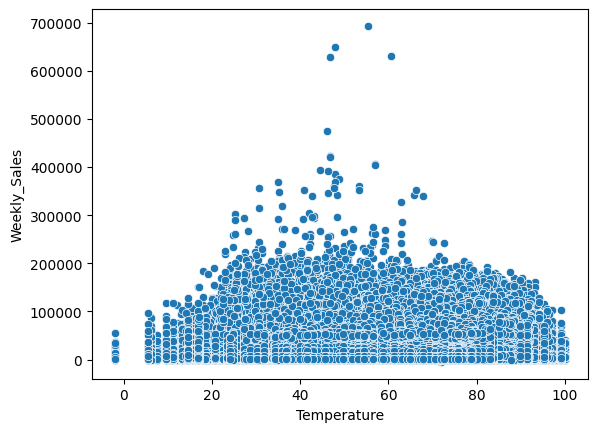

In [55]:
# WeeklySales per Temperature
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=train_merged)

This scatter plot illustrates the relationship between temperature and weekly sales. The distribution of points suggests that sales occur across a wide range of temperatures, with the highest concentration of sales falling between 40°F and 80°F. The plot also shows that extreme temperatures are less common and correspond to reduced sales.

<Axes: xlabel='Fuel_Price', ylabel='Weekly_Sales'>

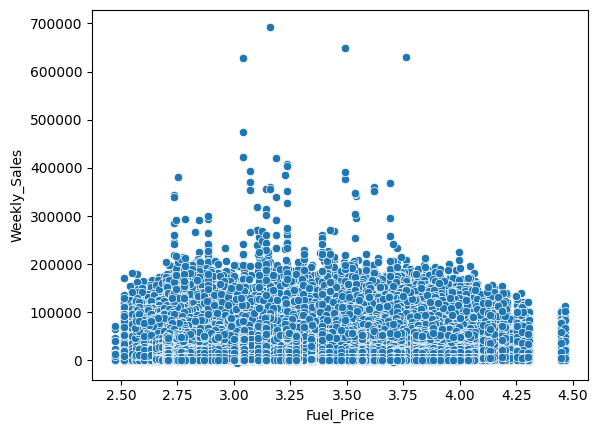

In [56]:
# WeeklySales per FuelPrice
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=train_merged)

<Axes: xlabel='CPI', ylabel='Weekly_Sales'>

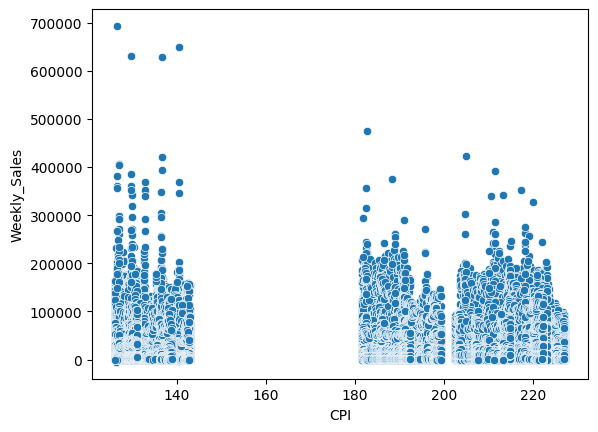

In [57]:
# WeeklySales per CPI
sns.scatterplot(x='CPI', y='Weekly_Sales', data=train_merged)

This scatter plot depicts the relationship between the Consumer Price Index (CPI) and weekly sales. The plot reveals a distinct bimodal distribution of CPI values, with clusters around 130-140 and 180-220, suggesting two distinct economic periods or regions in the dataset. Interestingly, the highest sales figures appear in both CPI ranges, indicating that high sales can occur regardless of the overall price level.

<Axes: xlabel='Type', ylabel='Weekly_Sales'>

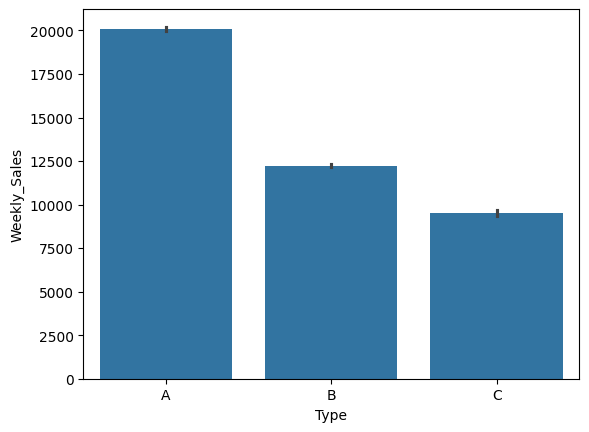

In [58]:
# WeeklySales per type (store)
sns.barplot(x='Type', y='Weekly_Sales', data=train_merged)

This bar graph compares average weekly sales across three store types: A, B, and C. Type A stores clearly outperform the others, with average sales about 60% higher than Type B and roughly double those of Type C. The substantial differences suggest distinct characteristics or strategies among these store types, possibly related to size, location, or product range.

<Axes: xlabel='Size', ylabel='Weekly_Sales'>

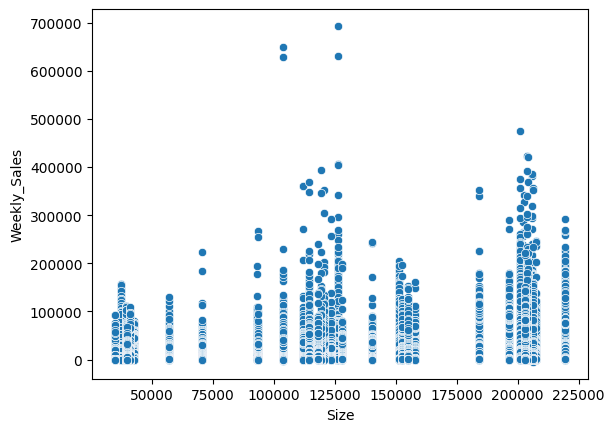

In [59]:
# WeeklySales per size (store)
sns.scatterplot(x='Size', y='Weekly_Sales', data=train_merged)

This scatter plot illustrates the relationship between store size and weekly sales. There's a clear positive correlation between size and sales potential, with larger stores generally achieving higher sales figures. However, the relationship isn't strictly linear; stores of similar sizes show a wide range of sales performance, indicating that factors beyond size significantly influence sales. Notably, the highest sales peaks occur in stores ranging from about 150,000 to 200,000 square feet, suggesting an optimal size range for maximizing sales potential. The clustered nature of the data points also implies that store sizes are standardized into distinct categories rather than being continuously variable.

<Axes: xlabel='Week', ylabel='Weekly_Sales'>

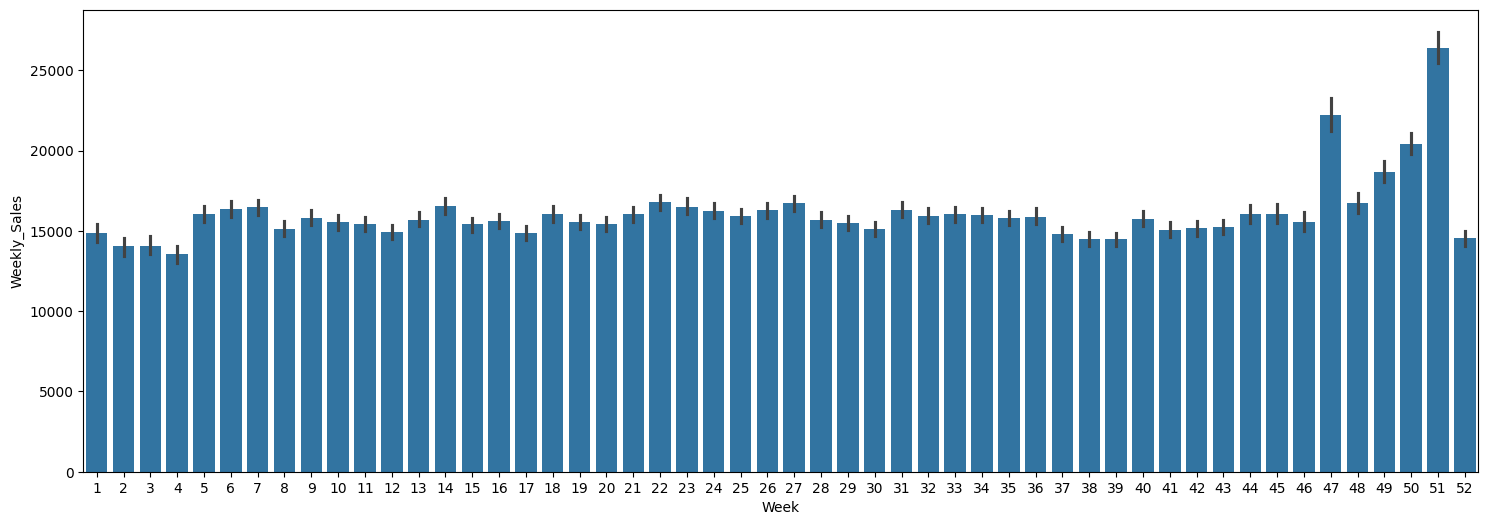

In [60]:
# weeklysales per week
plt.figure(figsize=(18, 6))
sns.barplot(x='Week', y='Weekly_Sales', data=train_merged)

This graph shows weekly sales data over the course of a year (52 weeks). Sales remain relatively stable around 15,000-17,000 for most of the year, with a noticeable spike in the last few weeks. This sharp increase likely corresponds to the holiday shopping season, with peaks in weeks 51 and 52 potentially representing Christmas and New Year's sales. There's also a smaller uptick around weeks 46-47, which could indicate Thanksgiving or Black Friday sales.

<Axes: xlabel='Month', ylabel='Weekly_Sales'>

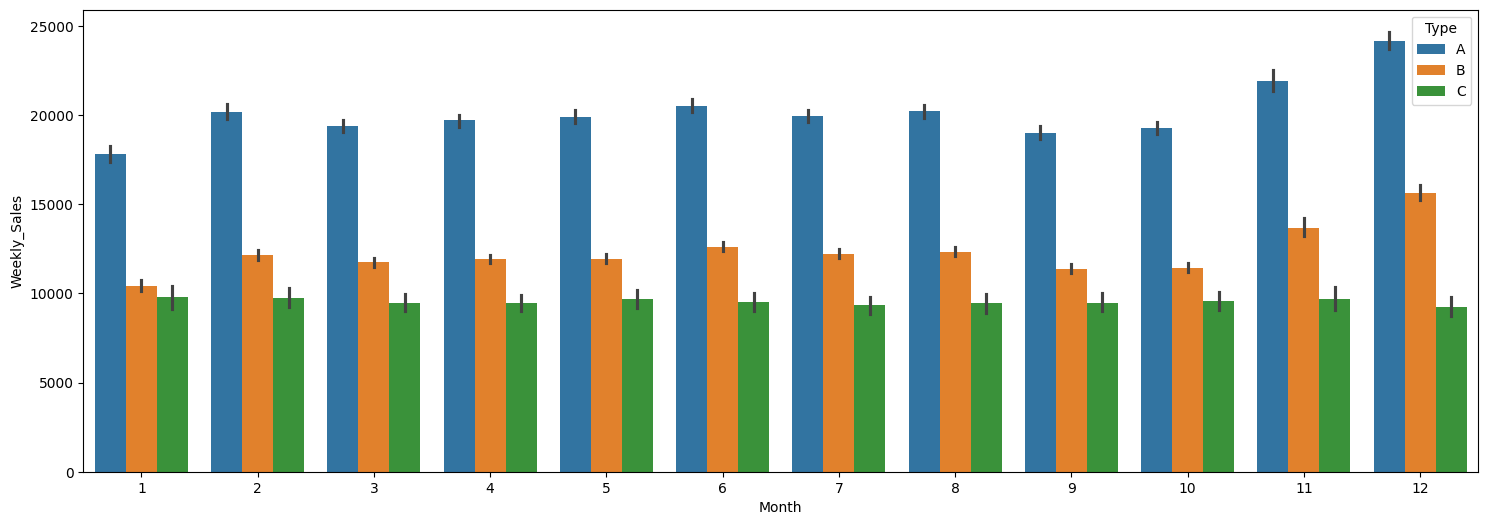

In [61]:
plt.figure(figsize=(18, 6))
sns.barplot(x='Month', y='Weekly_Sales', data=train_merged, hue="Type")

This graph shows monthly sales data for three types of shops (A, B, and C) over a year. Type A shops consistently have the highest sales, followed by Type B, then Type C. All shop types show a significant increase in sales during the last two months (November and December), likely due to holiday shopping. Type A shops experience the most dramatic rise, while Type C shops have the most stable sales throughout the year. There's also a noticeable peak for all shop types in August (month 8), possibly due to back-to-school shopping.

<Axes: xlabel='Year', ylabel='Weekly_Sales'>

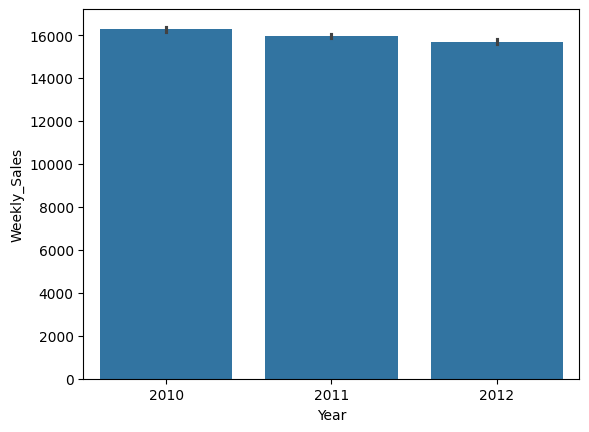

In [62]:
sns.barplot(x='Year', y='Weekly_Sales', data=train_merged)

Not detected big differences in weekly sales between years

#### Correlation calculation

In [38]:
# type is a categorical variable, calculate the mean Weekly_Sales for each Type to understand the relationship

type_sales_mean = train_merged.groupby('Type')['Weekly_Sales'].mean()

type_sales_mean

Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64

In [39]:
# or encode the different Type with one-hot encoding
# Label encode Type
train_merged['Type_encoded'] = train_merged['Type'].astype('category').cat.codes

# Calculate correlation
type_corr = train_merged[['Type_encoded', 'Weekly_Sales']].corr()

type_corr

,Type_encoded,Weekly_Sales
Type_encoded,1.000000,-0.182242
Weekly_Sales,-0.182242,1.000000


The correlation coefficient between Type (encoded as Type_encoded) and Weekly_Sales is -0.182242. This indicates a weak negative correlation, suggesting that certain store types might have slightly lower or higher sales, but the relationship is not strong. The negative sign implies that as the Type_encoded value increases, the Weekly_Sales tends to decrease slightly.

In [40]:
# We can directly calculate the Pearson correlation coefficient between Size and Weekly_Sales

size_corr = train_merged[['Size', 'Weekly_Sales']].corr()
print(size_corr)

                  Size  Weekly_Sales
Size          1.000000      0.243828
Weekly_Sales  0.243828      1.000000


The correlation coefficient between Size and Weekly_Sales is 0.243828. This indicates a weak positive correlation, suggesting that larger stores tend to have higher sales. The positive sign implies that as the store Size increases, the Weekly_Sales also tends to increase slightly.

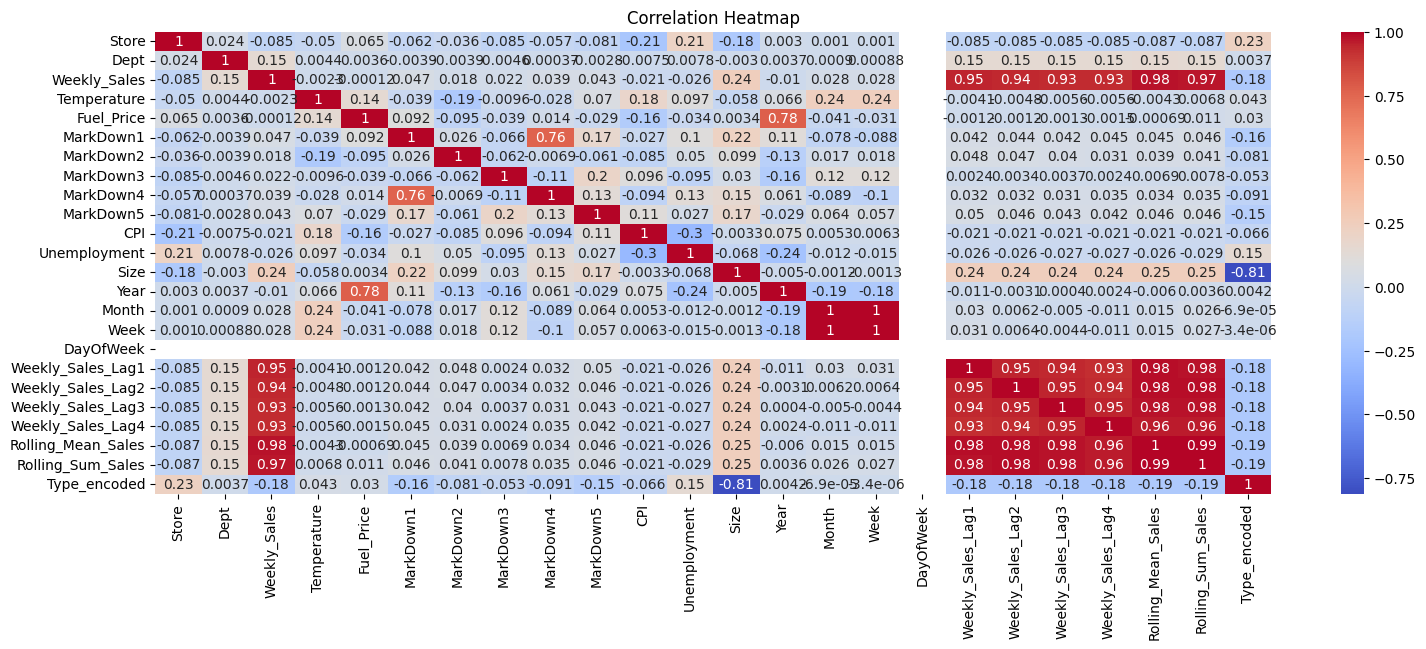

In [42]:
# Drop original categorical columns and keep only numeric columns
numeric_columns = train_merged.select_dtypes(include=['number']).columns
train_merged_numeric = train_merged[numeric_columns]

# Generate the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(train_merged_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The heatmap visualizes the correlation between various features in the dataset.

- Weekly_Sales and its lagged values (Weekly_Sales_Lag1 to Weekly_Sales_Lag4) show very high positive correlations (around 0.95 to 0.98). This indicates strong autocorrelation, meaning past sales are highly predictive of future sales.
- MarkDown4 and MarkDown1 (correlation = 0.76), suggesting that when MarkDown1 is applied, MarkDown4 is often applied as well.
- Size and Type_encoded have a high negative correlation (-0.81), indicating that certain store types tend to be larger or smaller.
- Size has a moderate positive correlation with Weekly_Sales (0.24), suggesting larger stores tend to have higher sales, but the relationship is not very strong.
- CPI and Unemployment have a moderate negative correlation (-0.3), which is expected as higher consumer prices are often associated with lower employment rates.
- Type_encoded has a weak negative correlation with Weekly_Sales (-0.18), indicating a slight trend where certain store types have different sales performance.
- Most MarkDown variables show weak correlations with Weekly_Sales, indicating that markdowns have a varying and complex effect on sales.
- Some features like Fuel_Price, Temperature, and certain MarkDown variables have very low or near-zero correlations with Weekly_Sales, suggesting minimal direct impact on sales.

## Data Preparation

In [14]:
# sort training set based on Date
train_sorted = train_merged.sort_values('Date')

In [15]:
# Determine the split point (e.g., use the last 30% of the data for validation)
split_point = int(len(train_sorted) * 0.7)

# Split the data
train_df = train_sorted.iloc[:split_point]
val_df = train_sorted.iloc[split_point:]

# Define features and target
features = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week']

X_train = train_df[features]
y_train = train_df['Weekly_Sales']
X_val = val_df[features]
y_val = val_df['Weekly_Sales']

In [28]:
X_train.shape

(295099, 15)

In [29]:
X_val.shape

(126471, 15)

Start with baseline models like linear regression or decision trees

In [14]:
def plot_learning_curve(model, X_train, y_train, X_val, y_val, model_name):
    train_errors = []
    val_errors = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        model.fit(X_train[:int(len(X_train)*size)], y_train[:int(len(y_train)*size)])
        
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        train_error = np.sqrt(mean_squared_error(y_train, train_pred))
        val_error = np.sqrt(mean_squared_error(y_val, val_pred))
        
        train_errors.append(train_error)
        val_errors.append(val_error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, label='Training Error')
    plt.plot(train_sizes, val_errors, label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend()
    plt.show()
    
    return model

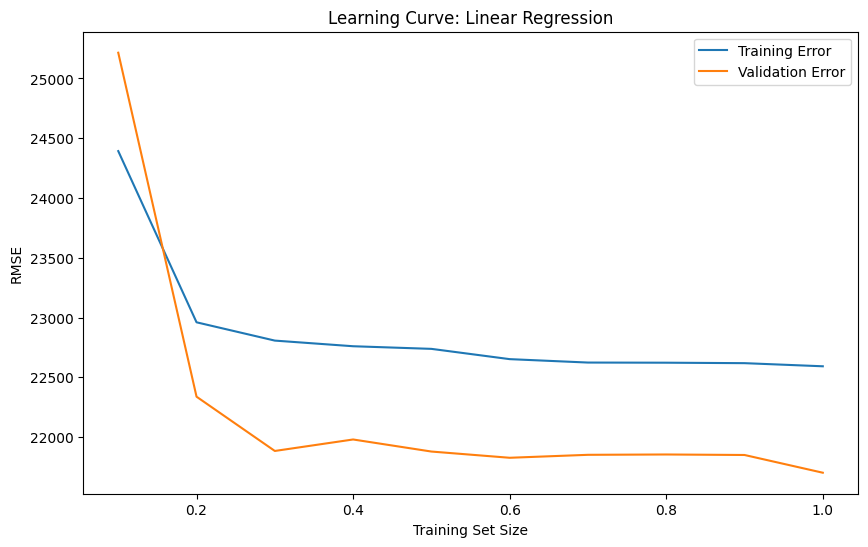

In [30]:
lr_model = LinearRegression()
lr_model = plot_learning_curve(lr_model, X_train, y_train, X_val, y_val, "Linear Regression")

The learning curve for the linear regression model displays a reasonable performance. The training error decreases steadily as the training set size increases, indicating that the model is learning the patterns in the data. The validation error also follows a similar trend, suggesting that the model is generalizing well to the unseen data. Overall, the relatively small gap between the training and validation errors suggests that the linear regression model has achieved a good balance between underfitting and overfitting.

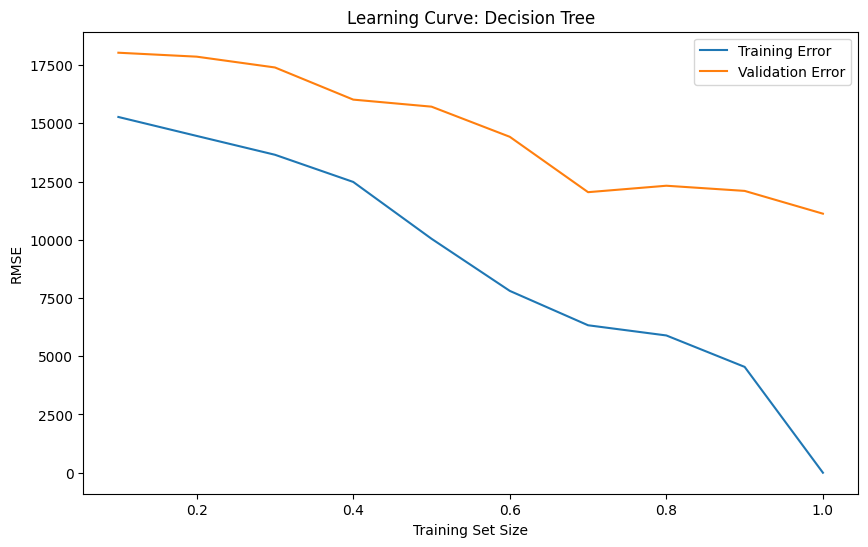

In [31]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model = plot_learning_curve(dt_model, X_train, y_train, X_val, y_val, "Decision Tree")

The learning curve for the Decision Tree model displays a better performance. The training error and validation error are closely aligned and decrease steadily as the training set size increases, indicating that the model is effectively learning the underlying patterns in the data without significant overfitting. The relatively low and converging training and validation errors across the different training set sizes demonstrate the strong generalization capability of the Decision Tree model for this dataset, suggesting it is well-suited to capture the complexities and provide reliable predictions.

Progress to more advanced models, such as: Random Forest, XGBoost and ARIMA

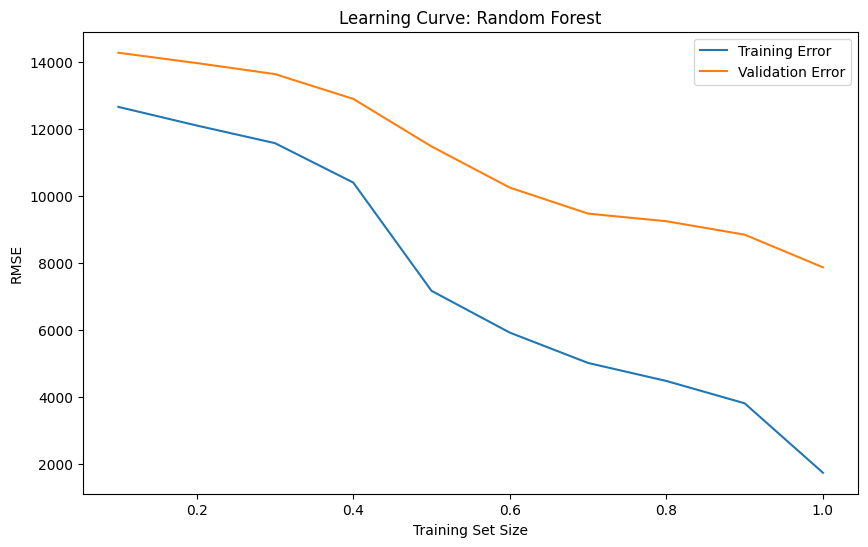

In [32]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model = plot_learning_curve(rf_model, X_train, y_train, X_val, y_val, "Random Forest")

The learning curve exhibits a very desirable behavior. Both the training error and validation error decrease steadily as the training set size increases, and the gap between the two remains relatively small throughout. This suggests that the Random Forest model is able to fit the training data well while maintaining strong generalization capabilities.

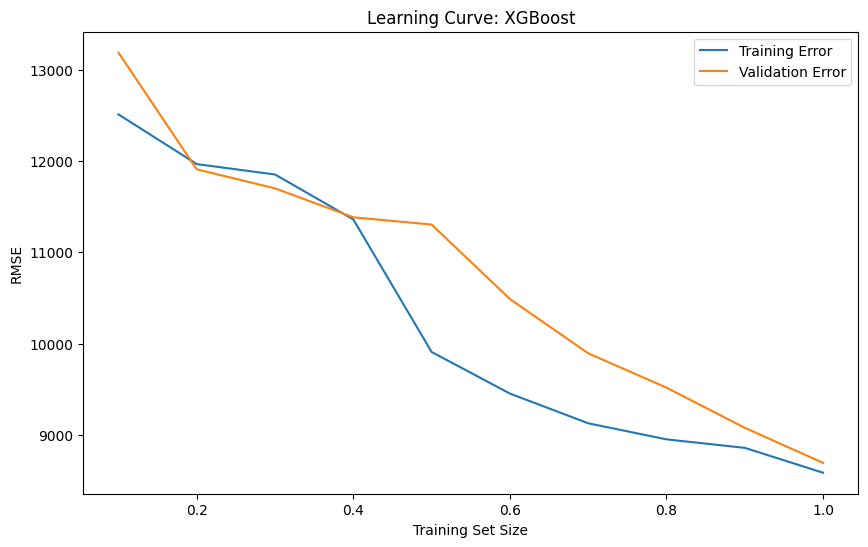

In [36]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model = plot_learning_curve(xgb_model, X_train, y_train, X_val, y_val, "XGBoost")

The XGBoost model's learning curve is equally impressive. The training error and validation error decrease rapidly as more training data is provided, and the two curves closely align across the entire range of training set sizes. This alignment demonstrates the model's ability to learn the underlying patterns in the data effectively without overfitting. 

## Try deep learning models

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [17]:
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer with one neuron for regression output
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [18]:
def plot_learning_curve_nn(model_fn, X_train, y_train, X_val, y_val, model_name, epochs=50):
    train_errors = []
    val_errors = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        # Create a new instance of the model
        model = model_fn(X_train.shape[1])
        
        # Fit the model on a subset of the data
        model.fit(X_train[:int(len(X_train) * size)], 
                  y_train[:int(len(y_train) * size)], 
                  epochs=epochs, 
                  verbose=0)  # Silent training
        
        # Predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        # Compute RMSE
        train_error = np.sqrt(mean_squared_error(y_train, train_pred))
        val_error = np.sqrt(mean_squared_error(y_val, val_pred))
        
        train_errors.append(train_error)
        val_errors.append(val_error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, label='Training Error')
    plt.plot(train_sizes, val_errors, label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend()
    plt.show()

    return model


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/Users/sofia/StoresSalesForecasting/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9222/9222 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


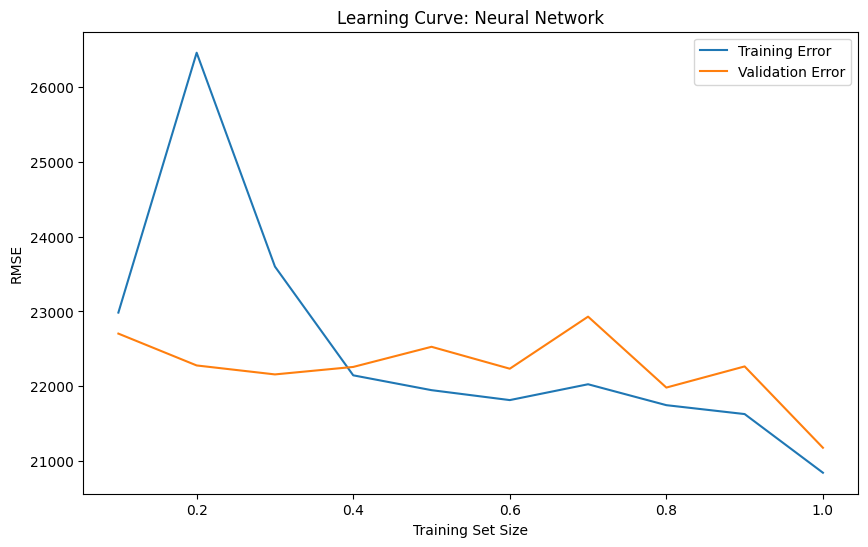

<Sequential name=sequential_11, built=True>

In [22]:
nn_model_fn = create_nn_model
plot_learning_curve_nn(nn_model_fn, X_train, y_train, X_val, y_val, "Neural Network", epochs=10)

The learning curve shows some interesting characteristics. The sharp drop and subsequent fluctuations in the training error indicate that the model is likely overfitting to the training data, as it is able to achieve very low training error but struggles to generalize well to the validation data.

### Weighted feature
Since the holiday weeks are weighted 5 times higher, it's important to ensure your models can effectively capture the impact of holidays and markdowns on sales.

In [30]:
def plot_learning_curve(model, X_train, y_train, X_val, y_val, model_name):
    train_errors = []
    val_errors = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        # Create a subset of the training data
        X_train_subset = X_train.iloc[:int(len(X_train)*size)].copy()
        y_train_subset = y_train.iloc[:int(len(y_train)*size)].copy()
        
        # Increase the weight of the 'IsHoliday' feature
        if 'IsHoliday' in X_train_subset.columns:
            X_train_subset['IsHoliday'] = X_train_subset['IsHoliday'] * 5
        if 'IsHoliday' in X_val.columns:
            X_val['IsHoliday'] = X_val['IsHoliday'] * 5
        
        # Train the model
        model.fit(X_train_subset, y_train_subset)
        
        # Make predictions
        train_pred = model.predict(X_train_subset)
        val_pred = model.predict(X_val)
        
        # Calculate RMSE
        train_error = np.sqrt(mean_squared_error(y_train_subset, train_pred))
        val_error = np.sqrt(mean_squared_error(y_val, val_pred))
        
        # Append errors to lists
        train_errors.append(train_error)
        val_errors.append(val_error)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, label='Training Error')
    plt.plot(train_sizes, val_errors, label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend()
    plt.show()
    
    return model


/var/folders/t9/2w32j6693bgcszqz42m0h9k00000gn/T/ipykernel_69511/2113803802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['IsHoliday'] = X_val['IsHoliday'] * 5
/var/folders/t9/2w32j6693bgcszqz42m0h9k00000gn/T/ipykernel_69511/2113803802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['IsHoliday'] = X_val['IsHoliday'] * 5
/var/folders/t9/2w32j6693bgcszqz42m0h9k00000gn/T/ipykernel_69511/2113803802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

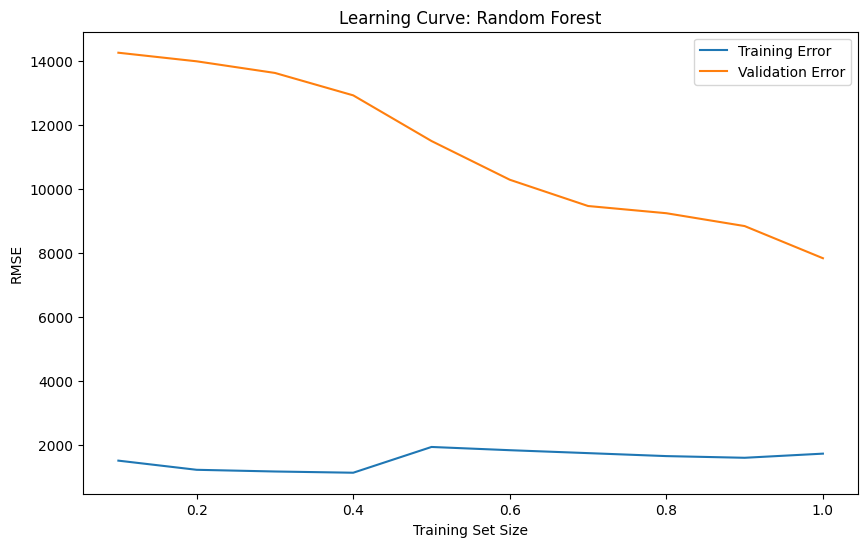

In [31]:
# Create and plot the Random Forest model with weighted 'IsHoliday' feature
rf_model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_2 = plot_learning_curve(rf_model_2, X_train, y_train, X_val, y_val, "Random Forest")

# Next steps

- NN: To improve the model's performance, we could consider techniques like regularization, dropout, or early stopping to prevent overfitting, as well as experimenting with different network architectures or hyperparameter configurations.